# GPU vs. CPU Running Time Test

We investigate the running time of GPytorch on CPU and GPU for training (150 iterations) and computing predictive distributions. For predictive distribution we also investigate the effect of LOVE approximation, so the scenarios are:
- CPU Exact
- GPU Exact
- CPU with LOVE without cache
- GPU with LOVE without cache
- CPU with LOVE with cache
- GPU with LOVE with cache

We use a customized Multitask Kernel with variable number of Kronecker Product, the same Kernel as used in Targeted Adaptive Design. We use 4 dimensional input and output.

The training and testing data are generated using sin and cos functions, etc.


In [32]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
# from Data_Gen_Script import VField
import numpy as np
from scipy.stats import uniform

import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from torch import nn
from torch import Tensor
from gpytorch.kernels import MultitaskKernel
from gpytorch.constraints import Positive




class TensorProductKernel(MultitaskKernel):
    """
    Class to get the tensorproduct kernel
    """

    def __init__(self, data_covar_module,  num_tasks, rank=1, pos_constraint = None, tri_constaint = None, task_covar_prior=None, **kwargs):
        super().__init__(data_covar_module, num_tasks, rank, task_covar_prior = None, **kwargs)

        
        
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, add_jitter = False, **params):
        if last_dim_is_batch:
            raise RuntimeError("MultitaskKernel does not accept the last_dim_is_batch argument.")
        covar_i = self.task_covar_module.covar_matrix #.evaluate()
            
        covar_i = covar_i.evaluate()
        if len(x1.shape[:-2]):
            covar_i = covar_i.repeat(*x1.shape[:-2], 1, 1)
        covar_x = gpytorch.lazy.lazify(self.data_covar_module.forward(x1, x2, **params))#(self.data_covar_module.forward(x1, x2, **params))#
        if (add_jitter == True):
            covar_x = covar_x #+ (1e-6) * torch.eye(covar_x.shape[0])
        res=gpytorch.lazy.KroneckerProductLazyTensor(covar_x, covar_i) #gpytorch.lazy.lazify(torch.kron(covar_x, covar_i))

        return res.diag() if diag else res
        
        
from copy import deepcopy
from typing import List, Optional, Union

from torch.nn import ModuleList

from gpytorch.priors import Prior
from gpytorch.kernels import Kernel
from gpytorch.kernels import IndexKernel
from gpytorch.constraints import Positive

# This is the main Kernel to use

class SepTensorProductKernel(Kernel):
    """
    Class to get the tensorproduct kernel
    """

    def __init__(
        self, base_kernels: List, num_tasks: int, rank: Union[int, List] = 1, 
        task_covar_prior: Optional[Prior] = None
    ):
        """
        Args:
            base_kernels (:type: list of `Kernel` objects): A list of base kernels.
            num_tasks (int): The number of output tasks to fit.
            rank (int): Rank of index kernel to use for task covariance matrix for each
                        of the base kernels.
            task_covar_prior (:obj:`gpytorch.priors.Prior`): Prior to use for each
                task kernel. See :class:`gpytorch.kernels.IndexKernel` for details.
        """
        if len(base_kernels) < 1:
            raise ValueError("At least one base kernel must be provided.")
        for k in base_kernels:
            if not isinstance(k, Kernel):
                raise ValueError("base_kernels must only contain Kernel objects")
        if not isinstance(rank, list):
            rank = [rank] * len(base_kernels)

        super(SepTensorProductKernel, self).__init__()
        self.covar_module_list = ModuleList(
            [
                TensorProductKernel(base_kernel, num_tasks=num_tasks, rank=r, task_covar_prior=task_covar_prior)
                for base_kernel, r in zip(base_kernels, rank)
            ]
        )

    def forward(self, x1, x2, **params):
        res = self.covar_module_list[0].forward(x1, x2, **params)
        for m in self.covar_module_list[1:]:
            res += m.forward(x1, x2, **params)
        return res

    def num_outputs_per_input(self, x1, x2):
        """
        Given `n` data points `x1` and `m` datapoints `x2`, this multitask kernel
        returns an `(n*num_tasks) x (m*num_tasks)` covariance matrix.
        """
        return self.covar_module_list[0].num_outputs_per_input(x1, x2)


    def __getitem__(self, index):
        new_kernel = deepcopy(self)
        new_kernel.covar_module_list = ModuleList(
            [base_kernel.__getitem__(index) for base_kernel in self.covar_module_list]
        )
        return new_kernel



In [34]:
"""
Model Initialization
"""

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_base_kernels):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        
        self.mean_module = gpytorch.means.MultitaskMean(
              gpytorch.means.ConstantMean(), num_tasks=Dval
        )
        
        base_kernels = []
        for i in range(num_base_kernels):
            base_kernels.append(gpytorch.kernels.ScaleKernel(( gpytorch.kernels.RBFKernel() ))) 
            #gpytorch.kernels.PolynomialKernel(4)  ##gpytorch.kernels.MaternKernel()# (vvk_rbf.vvkRBFKernel())
 
            
        self.covar_module = SepTensorProductKernel(base_kernels,num_tasks = Dval)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

num_base_kernels = 8

In [35]:
cpu_training_time = []
cpu_exact_meancovar = []
cpu_love_meancovar = []
cpu_love_meancovar_cache = []

In [36]:
cpu_size_vec = [100,300,500,700,1000,1500,2000]
Nval = 4
Dval = 4

for size in cpu_size_vec:
    print(f"data size: {size}")
    """Set up the training and testing data"""
    n = size # input size

#     x = 5 * torch.rand(n, Dval)

#     y = torch.stack([
#         torch.sin(x[:, 0] * (2 * math.pi)) + torch.randn(n) * 0.02,
#         torch.cos(x[:, 0] * (2 * math.pi)) + torch.cos(x[:, 2] * (2 * math.pi)) + torch.randn(n) * 0.02,
#         torch.sin(x[:, 2] * (2 * math.pi)) + torch.cos(x[:, 1] * (2 * math.pi)) + torch.randn(n) * 0.02,
#         (torch.cos(x[:, 3] * (2 * math.pi)))* (torch.sin(x[:, 0] * (2 * math.pi))) + torch.randn(n) * 0.02,
#     ], -1)

    x = 3 * torch.rand(n)
    
    y = torch.stack([
        torch.sin(3 * x) + torch.randn(n) * 0.01,
        torch.cos(x) + torch.cos(2 * x) + torch.randn(n) * 0.01,
        torch.sin(x) + torch.cos(x) + torch.randn(n) * 0.01,
        torch.cos(x) * torch.cos(x) + torch.randn(n) * 0.01,
    ], -1)

    train_x = x[:int(0.8*n)]
    train_y = y[:int(0.8*n)]

    test_x = x[int(0.8*n): ]

    test_y = y[int(0.8*n): ]

#     # normalize features
#     mean = train_x.mean()
#     std = train_x.std() + 1e-6 # prevent dividing by 0
#     train_x = (train_x - mean) / std
#     test_x = (test_x - mean) / std

#     # normalize labels
#     mean, std = train_y.mean(),train_y.std()
#     train_y = (train_y - mean) / std
#     test_y = (test_y - mean) / std

    
    
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=Dval)
    model = MultitaskGPModel(train_x, train_y, likelihood, num_base_kernels)
    
    start_time = time.time()
    
    """train the model hyperparameters"""
    training_iterations = 150

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
#           if(i > training_iterations*0.8):
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()
    
    cpu_training_time.append(time.time() - start_time)
    
    print()
    
    """ Making predictions with the model"""
    # Set into eval mode
    model.eval()
    likelihood.eval()

    # Exact predictions
    with torch.no_grad(): #, gpytorch.settings.fast_pred_var():
        start_time = time.time()
        preds = model(test_x) # no noise
        covar = preds.covariance_matrix
        cpu_exact_meancovar.append(time.time() - start_time)
    
    
    
    # LOVE without cache
        # Clear the cache from the previous computations
    model.train()
    likelihood.train()
    # Set into eval mode
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        start_time = time.time()
        preds = model(test_x)
        fast_covar = preds.covariance_matrix
        cpu_love_meancovar.append(time.time() - start_time)
    
    # LOVE with cache
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        start_time = time.time()
        preds = model(test_x)
        fast_covar = preds.covariance_matrix
        cpu_love_meancovar_cache.append(time.time() - start_time)  


data size: 100
Iter 1/150 - Loss: 1.217
Iter 2/150 - Loss: 1.194
Iter 3/150 - Loss: 1.172
Iter 4/150 - Loss: 1.150
Iter 5/150 - Loss: 1.128
Iter 6/150 - Loss: 1.106
Iter 7/150 - Loss: 1.084
Iter 8/150 - Loss: 1.063
Iter 9/150 - Loss: 1.042
Iter 10/150 - Loss: 1.021
Iter 11/150 - Loss: 1.000
Iter 12/150 - Loss: 0.980
Iter 13/150 - Loss: 0.959
Iter 14/150 - Loss: 0.938
Iter 15/150 - Loss: 0.917
Iter 16/150 - Loss: 0.896
Iter 17/150 - Loss: 0.875
Iter 18/150 - Loss: 0.853
Iter 19/150 - Loss: 0.831
Iter 20/150 - Loss: 0.808
Iter 21/150 - Loss: 0.786
Iter 22/150 - Loss: 0.763
Iter 23/150 - Loss: 0.741
Iter 24/150 - Loss: 0.718
Iter 25/150 - Loss: 0.696
Iter 26/150 - Loss: 0.674
Iter 27/150 - Loss: 0.652
Iter 28/150 - Loss: 0.629
Iter 29/150 - Loss: 0.607
Iter 30/150 - Loss: 0.584
Iter 31/150 - Loss: 0.561
Iter 32/150 - Loss: 0.538
Iter 33/150 - Loss: 0.515
Iter 34/150 - Loss: 0.491
Iter 35/150 - Loss: 0.467
Iter 36/150 - Loss: 0.444
Iter 37/150 - Loss: 0.420
Iter 38/150 - Loss: 0.396
Iter 3

Iter 4/150 - Loss: 1.066
Iter 5/150 - Loss: 1.045
Iter 6/150 - Loss: 1.022
Iter 7/150 - Loss: 1.006
Iter 8/150 - Loss: 0.991
Iter 9/150 - Loss: 0.966
Iter 10/150 - Loss: 0.951
Iter 11/150 - Loss: 0.929
Iter 12/150 - Loss: 0.904
Iter 13/150 - Loss: 0.885
Iter 14/150 - Loss: 0.861
Iter 15/150 - Loss: 0.850
Iter 16/150 - Loss: 0.822
Iter 17/150 - Loss: 0.805
Iter 18/150 - Loss: 0.781
Iter 19/150 - Loss: 0.760
Iter 20/150 - Loss: 0.735
Iter 21/150 - Loss: 0.716
Iter 22/150 - Loss: 0.689
Iter 23/150 - Loss: 0.669
Iter 24/150 - Loss: 0.653
Iter 25/150 - Loss: 0.624
Iter 26/150 - Loss: 0.600
Iter 27/150 - Loss: 0.579
Iter 28/150 - Loss: 0.558
Iter 29/150 - Loss: 0.529
Iter 30/150 - Loss: 0.506
Iter 31/150 - Loss: 0.483
Iter 32/150 - Loss: 0.460
Iter 33/150 - Loss: 0.438
Iter 34/150 - Loss: 0.408
Iter 35/150 - Loss: 0.388
Iter 36/150 - Loss: 0.364
Iter 37/150 - Loss: 0.340
Iter 38/150 - Loss: 0.313
Iter 39/150 - Loss: 0.295
Iter 40/150 - Loss: 0.263
Iter 41/150 - Loss: 0.241
Iter 42/150 - Loss

Iter 8/150 - Loss: 0.995
Iter 9/150 - Loss: 0.975
Iter 10/150 - Loss: 0.956
Iter 11/150 - Loss: 0.937
Iter 12/150 - Loss: 0.917
Iter 13/150 - Loss: 0.898
Iter 14/150 - Loss: 0.877
Iter 15/150 - Loss: 0.857
Iter 16/150 - Loss: 0.837
Iter 17/150 - Loss: 0.818
Iter 18/150 - Loss: 0.796
Iter 19/150 - Loss: 0.775
Iter 20/150 - Loss: 0.754
Iter 21/150 - Loss: 0.733
Iter 22/150 - Loss: 0.712
Iter 23/150 - Loss: 0.689
Iter 24/150 - Loss: 0.668
Iter 25/150 - Loss: 0.646
Iter 26/150 - Loss: 0.623
Iter 27/150 - Loss: 0.601
Iter 28/150 - Loss: 0.578
Iter 29/150 - Loss: 0.555
Iter 30/150 - Loss: 0.533
Iter 31/150 - Loss: 0.509
Iter 32/150 - Loss: 0.486
Iter 33/150 - Loss: 0.463
Iter 34/150 - Loss: 0.439
Iter 35/150 - Loss: 0.415
Iter 36/150 - Loss: 0.392
Iter 37/150 - Loss: 0.368
Iter 38/150 - Loss: 0.343
Iter 39/150 - Loss: 0.319
Iter 40/150 - Loss: 0.295
Iter 41/150 - Loss: 0.271
Iter 42/150 - Loss: 0.246
Iter 43/150 - Loss: 0.221
Iter 44/150 - Loss: 0.196
Iter 45/150 - Loss: 0.171
Iter 46/150 - 

/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.0702104568481445 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 150/150 - Loss: nan



/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.156534194946289 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(
/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.6978683471679688 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


data size: 2000
Iter 1/150 - Loss: 1.096
Iter 2/150 - Loss: 1.091
Iter 3/150 - Loss: 1.075
Iter 4/150 - Loss: 1.057
Iter 5/150 - Loss: 1.041
Iter 6/150 - Loss: 1.021
Iter 7/150 - Loss: 1.003
Iter 8/150 - Loss: 0.985
Iter 9/150 - Loss: 0.966
Iter 10/150 - Loss: 0.948
Iter 11/150 - Loss: 0.929
Iter 12/150 - Loss: 0.910
Iter 13/150 - Loss: 0.890
Iter 14/150 - Loss: 0.870
Iter 15/150 - Loss: 0.850
Iter 16/150 - Loss: 0.830
Iter 17/150 - Loss: 0.810
Iter 18/150 - Loss: 0.789
Iter 19/150 - Loss: 0.768
Iter 20/150 - Loss: 0.746
Iter 21/150 - Loss: 0.725
Iter 22/150 - Loss: 0.704
Iter 23/150 - Loss: 0.682
Iter 24/150 - Loss: 0.661
Iter 25/150 - Loss: 0.638
Iter 26/150 - Loss: 0.615
Iter 27/150 - Loss: 0.594
Iter 28/150 - Loss: 0.570
Iter 29/150 - Loss: 0.548
Iter 30/150 - Loss: 0.525
Iter 31/150 - Loss: 0.502
Iter 32/150 - Loss: 0.478
Iter 33/150 - Loss: 0.455
Iter 34/150 - Loss: 0.431
Iter 35/150 - Loss: 0.408
Iter 36/150 - Loss: 0.383
Iter 37/150 - Loss: 0.359
Iter 38/150 - Loss: 0.335
Iter 

/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.6248997449874878 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 144/150 - Loss: nan
Iter 145/150 - Loss: nan


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.6809377670288086 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 146/150 - Loss: nan


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.4910030364990234 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 147/150 - Loss: nan


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.67107355594635 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 148/150 - Loss: nan


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.013857841491699 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 149/150 - Loss: nan


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.777685284614563 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 150/150 - Loss: nan



/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 5.137876987457275 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(
/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.4686453640460968 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


In [37]:
print(cpu_training_time)
print(cpu_exact_meancovar)
print(cpu_love_meancovar)
print(cpu_love_meancovar_cache)

[6.7813191413879395, 20.281359434127808, 29.221570014953613, 29.987565994262695, 34.28912806510925, 111.40788269042969, 270.16520977020264]
[0.2011868953704834, 0.47016167640686035, 0.6492369174957275, 1.2938873767852783, 4.657888650894165, 205.26769304275513, 727.7417969703674]
[0.05069756507873535, 0.44669389724731445, 0.5175209045410156, 0.4238770008087158, 0.6530847549438477, 5.922862768173218, 14.493090867996216]
[0.016495704650878906, 0.056517839431762695, 0.07649540901184082, 0.06994819641113281, 0.11183714866638184, 0.21816301345825195, 0.37868762016296387]


In [38]:
# # Initialize plots
# f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(15, 10))

# # This contains predictions for both tasks, flattened out
# # The first half of the predictions is for the first task
# # The second half is for the second task

# # Plot training data as black stars
# y1_ax.plot(train_x[:, 0].detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# # Predictive mean as blue line
# y1_ax.plot(test_x[:, 0].numpy(), preds.mean[:, 0].numpy(), 'b')
# # Shade in confidence
# # y1_ax.fill_between(test_x[:, 0].numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
# # y1_ax.set_ylim([-3, 3])
# y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
# y1_ax.set_title('Observed Values (Likelihood)')

# # Plot training data as black stars
# y2_ax.plot(train_x[:, 1].detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# # Predictive mean as blue line
# y2_ax.plot(test_x[:, 1].numpy(), preds.mean[:, 1].numpy(), 'b')
# # Shade in confidence
# # y2_ax.fill_between(test_x[:, 1].numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
# # y2_ax.set_ylim([-3, 3])
# y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
# y2_ax.set_title('Observed Values (Likelihood)')

# None

In [39]:
gpu_training_time = []
gpu_exact_meancovar = []
gpu_love_meancovar = []
gpu_love_meancovar_cache = []
love_covar_error = []

In [40]:
gpu_size_vec = [100,300,500,700,1000,1500,2000,3000,4000,5000,6000,7000]
Nval = 4
Dval = 4

for size in gpu_size_vec:
    print(f"data size: {size}")
    """Set up the training and testing data"""
    n = size # input size

#     x = 5 * torch.rand(n, Dval)

#     y = torch.stack([
#         torch.sin(x[:, 0] * (2 * math.pi)) + torch.randn(n) * 0.02,
#         torch.cos(x[:, 0] * (2 * math.pi)) + torch.cos(x[:, 2] * (2 * math.pi)) + torch.randn(n) * 0.02,
#         torch.sin(x[:, 2] * (2 * math.pi)) + torch.cos(x[:, 1] * (2 * math.pi)) + torch.randn(n) * 0.02,
#         (torch.cos(x[:, 3] * (2 * math.pi)))* (torch.sin(x[:, 0] * (2 * math.pi))) + torch.randn(n) * 0.02,
#     ], -1)

    x = 5 * torch.rand(n)
    
    y = torch.stack([
        torch.sin(3 * x) + torch.randn(n) * 0.02,
        torch.cos(x) + torch.cos(2 * x) + torch.randn(n) * 0.02,
        torch.sin(x) + torch.cos(x) + torch.randn(n) * 0.02,
        torch.cos(x) * torch.cos(x) + torch.randn(n) * 0.02,
    ], -1)

#     train_x = torch.Tensor(x[:int(0.8*n), :])
#     train_y = y[:int(0.8*n), :]

#     test_x = torch.Tensor(x[int(0.8*n):, :])

#     test_y = torch.Tensor(y[int(0.8*n):, :])

    train_x = x[:int(0.8*n)]
    train_y = y[:int(0.8*n)]

    test_x = x[int(0.8*n): ]

    test_y = y[int(0.8*n): ]

#     # normalize features
#     mean = train_x.mean(dim=-2, keepdim=True)
#     std = train_x.std(dim=-2, keepdim=True) # + 1e-6 # prevent dividing by 0
#     train_x = (train_x - mean) / std
#     test_x = (test_x - mean) / std

#     # normalize labels
#     mean, std = train_y.mean(),train_y.std()
#     train_y = (train_y - mean) / std
#     test_y = (test_y - mean) / std

#     norm_vec = (vec - mean) / std
    
    
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=Dval)
    model = MultitaskGPModel(train_x, train_y, likelihood, num_base_kernels)
    
    start_time = time.time() # include the time of copying values onto gpu
    
    use_cuda = torch.cuda.is_available()
    print(f"Use Cuda: {use_cuda}")
    if(use_cuda):
        train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()
        model, likelihood = model.cuda(), likelihood.cuda()
    
    """train the model hyperparameters"""
    import os
    smoke_test = ('CI' in os.environ)
    training_iterations = 2 if smoke_test else 90

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.09)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
#           if(i > training_iterations*0.8):
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()
    
    gpu_training_time.append(time.time() - start_time)
    
    print()
    
    """ Making predictions with the model"""
    # Set into eval mode
    model.eval()
    likelihood.eval()

    # Exact predictions
    with torch.no_grad(): #, gpytorch.settings.fast_pred_var():
        start_time = time.time()
        preds = model(test_x) # no noise
        covar = preds.covariance_matrix
        gpu_exact_meancovar.append(time.time() - start_time)
    
    
    
    # LOVE without cache
        # Clear the cache from the previous computations
    model.train()
    likelihood.train()
    # Set into eval mode
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        start_time = time.time()
        preds = model(test_x)
        fast_covar = preds.covariance_matrix
        gpu_love_meancovar.append(time.time() - start_time)
        
        
#     """
#     Compute sum of squared difference LOVE diagonal covariance elements from exact diagonal elements 
#     (again divided by trace of exact covariance to make the quantity normalized), as a function
#     of vector size
#     """
    
#     exactdiag = torch.diagonal(covar)
#     lovediag = torch.diagonal(fast_covar)
    
# #     exactdiag = torch.diagonal(covar).log()
# #     lovediag = torch.diagonal(fast_covar).log()
#     diff = (exactdiag - lovediag).square().mean().sqrt()
#     print(diff)
#     diff = diff / exactdiag.square().mean().sqrt()
#     love_covar_error.append(diff)
#     print(f"error: {diff}")
    
    # LOVE with cache
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        start_time = time.time()
        preds = model(test_x)
        fast_covar = preds.covariance_matrix
        gpu_love_meancovar_cache.append(time.time() - start_time)  


data size: 100
Use Cuda: True
Iter 1/90 - Loss: 1.263
Iter 2/90 - Loss: 1.220
Iter 3/90 - Loss: 1.178
Iter 4/90 - Loss: 1.137
Iter 5/90 - Loss: 1.098
Iter 6/90 - Loss: 1.060
Iter 7/90 - Loss: 1.023
Iter 8/90 - Loss: 0.986
Iter 9/90 - Loss: 0.950
Iter 10/90 - Loss: 0.913
Iter 11/90 - Loss: 0.876
Iter 12/90 - Loss: 0.839
Iter 13/90 - Loss: 0.800
Iter 14/90 - Loss: 0.761
Iter 15/90 - Loss: 0.720
Iter 16/90 - Loss: 0.680
Iter 17/90 - Loss: 0.640
Iter 18/90 - Loss: 0.601
Iter 19/90 - Loss: 0.562
Iter 20/90 - Loss: 0.523
Iter 21/90 - Loss: 0.483
Iter 22/90 - Loss: 0.442
Iter 23/90 - Loss: 0.400
Iter 24/90 - Loss: 0.358
Iter 25/90 - Loss: 0.316
Iter 26/90 - Loss: 0.273
Iter 27/90 - Loss: 0.231
Iter 28/90 - Loss: 0.188
Iter 29/90 - Loss: 0.145
Iter 30/90 - Loss: 0.103
Iter 31/90 - Loss: 0.060
Iter 32/90 - Loss: 0.017
Iter 33/90 - Loss: -0.026
Iter 34/90 - Loss: -0.069
Iter 35/90 - Loss: -0.112
Iter 36/90 - Loss: -0.156
Iter 37/90 - Loss: -0.199
Iter 38/90 - Loss: -0.242
Iter 39/90 - Loss: -0.2

Iter 49/90 - Loss: -0.835
Iter 50/90 - Loss: -0.880
Iter 51/90 - Loss: -0.921
Iter 52/90 - Loss: -0.967
Iter 53/90 - Loss: -1.015
Iter 54/90 - Loss: -1.060
Iter 55/90 - Loss: -1.101
Iter 56/90 - Loss: -1.148
Iter 57/90 - Loss: -1.193
Iter 58/90 - Loss: -1.237
Iter 59/90 - Loss: -1.277
Iter 60/90 - Loss: -1.324
Iter 61/90 - Loss: -1.367
Iter 62/90 - Loss: -1.409
Iter 63/90 - Loss: -1.447
Iter 64/90 - Loss: -1.486
Iter 65/90 - Loss: -1.528
Iter 66/90 - Loss: -1.575
Iter 67/90 - Loss: -1.614
Iter 68/90 - Loss: -1.659
Iter 69/90 - Loss: -1.703
Iter 70/90 - Loss: -1.731
Iter 71/90 - Loss: -1.768
Iter 72/90 - Loss: -1.809
Iter 73/90 - Loss: -1.845
Iter 74/90 - Loss: -1.886
Iter 75/90 - Loss: -1.916
Iter 76/90 - Loss: -1.965
Iter 77/90 - Loss: -1.996
Iter 78/90 - Loss: -2.034
Iter 79/90 - Loss: -2.075
Iter 80/90 - Loss: -2.089
Iter 81/90 - Loss: -2.138
Iter 82/90 - Loss: -2.183
Iter 83/90 - Loss: -2.214
Iter 84/90 - Loss: -2.261
Iter 85/90 - Loss: -2.297
Iter 86/90 - Loss: -2.311
Iter 87/90 -

/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.16609950363636017 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(
/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.12796521186828613 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


data size: 1500
Use Cuda: True
Iter 1/90 - Loss: 1.107
Iter 2/90 - Loss: 1.096
Iter 3/90 - Loss: 1.068
Iter 4/90 - Loss: 1.035
Iter 5/90 - Loss: 1.003
Iter 6/90 - Loss: 0.971
Iter 7/90 - Loss: 0.936
Iter 8/90 - Loss: 0.902
Iter 9/90 - Loss: 0.867
Iter 10/90 - Loss: 0.833
Iter 11/90 - Loss: 0.795
Iter 12/90 - Loss: 0.758
Iter 13/90 - Loss: 0.721
Iter 14/90 - Loss: 0.683
Iter 15/90 - Loss: 0.644
Iter 16/90 - Loss: 0.604
Iter 17/90 - Loss: 0.565
Iter 18/90 - Loss: 0.525
Iter 19/90 - Loss: 0.484
Iter 20/90 - Loss: 0.442
Iter 21/90 - Loss: 0.403
Iter 22/90 - Loss: 0.360
Iter 23/90 - Loss: 0.316
Iter 24/90 - Loss: 0.275
Iter 25/90 - Loss: 0.230
Iter 26/90 - Loss: 0.187
Iter 27/90 - Loss: 0.144
Iter 28/90 - Loss: 0.099
Iter 29/90 - Loss: 0.055
Iter 30/90 - Loss: 0.010
Iter 31/90 - Loss: -0.034
Iter 32/90 - Loss: -0.081
Iter 33/90 - Loss: -0.125
Iter 34/90 - Loss: -0.170
Iter 35/90 - Loss: -0.217
Iter 36/90 - Loss: -0.262
Iter 37/90 - Loss: -0.307
Iter 38/90 - Loss: -0.353
Iter 39/90 - Loss: -

/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.5061639547348022 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 88/90 - Loss: -2.287


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.8025588989257812 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 89/90 - Loss: -2.300
Iter 90/90 - Loss: -2.544



/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.2306578159332275 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(
/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.789131760597229 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


data size: 3000
Use Cuda: True
Iter 1/90 - Loss: 1.095
Iter 2/90 - Loss: 1.087
Iter 3/90 - Loss: 1.058
Iter 4/90 - Loss: 1.026
Iter 5/90 - Loss: 0.995
Iter 6/90 - Loss: 0.962
Iter 7/90 - Loss: 0.928
Iter 8/90 - Loss: 0.895
Iter 9/90 - Loss: 0.859
Iter 10/90 - Loss: 0.823
Iter 11/90 - Loss: 0.787
Iter 12/90 - Loss: 0.750
Iter 13/90 - Loss: 0.713
Iter 14/90 - Loss: 0.676
Iter 15/90 - Loss: 0.635
Iter 16/90 - Loss: 0.596
Iter 17/90 - Loss: 0.556
Iter 18/90 - Loss: 0.516
Iter 19/90 - Loss: 0.475
Iter 20/90 - Loss: 0.434
Iter 21/90 - Loss: 0.392
Iter 22/90 - Loss: 0.350
Iter 23/90 - Loss: 0.308
Iter 24/90 - Loss: 0.265
Iter 25/90 - Loss: 0.222
Iter 26/90 - Loss: 0.179
Iter 27/90 - Loss: 0.133
Iter 28/90 - Loss: 0.090
Iter 29/90 - Loss: 0.046
Iter 30/90 - Loss: 0.000
Iter 31/90 - Loss: -0.044
Iter 32/90 - Loss: -0.090
Iter 33/90 - Loss: -0.135
Iter 34/90 - Loss: -0.180
Iter 35/90 - Loss: -0.227
Iter 36/90 - Loss: -0.272
Iter 37/90 - Loss: -0.317
Iter 38/90 - Loss: -0.365
Iter 39/90 - Loss: -

/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.0235408544540405 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 87/90 - Loss: -2.282


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.0811233520507812 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 88/90 - Loss: -2.294
Iter 89/90 - Loss: -2.302
Iter 90/90 - Loss: -2.420



/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.8309599161148071 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(
/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.7946535348892212 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


data size: 4000
Use Cuda: True
Iter 1/90 - Loss: 1.093
Iter 2/90 - Loss: 1.085
Iter 3/90 - Loss: 1.055
Iter 4/90 - Loss: 1.024
Iter 5/90 - Loss: 0.992
Iter 6/90 - Loss: 0.959
Iter 7/90 - Loss: 0.926
Iter 8/90 - Loss: 0.891
Iter 9/90 - Loss: 0.857
Iter 10/90 - Loss: 0.821
Iter 11/90 - Loss: 0.785
Iter 12/90 - Loss: 0.748
Iter 13/90 - Loss: 0.710
Iter 14/90 - Loss: 0.672
Iter 15/90 - Loss: 0.633
Iter 16/90 - Loss: 0.594
Iter 17/90 - Loss: 0.555
Iter 18/90 - Loss: 0.514
Iter 19/90 - Loss: 0.474
Iter 20/90 - Loss: 0.432
Iter 21/90 - Loss: 0.390
Iter 22/90 - Loss: 0.348
Iter 23/90 - Loss: 0.306
Iter 24/90 - Loss: 0.263
Iter 25/90 - Loss: 0.219
Iter 26/90 - Loss: 0.176
Iter 27/90 - Loss: 0.132
Iter 28/90 - Loss: 0.088
Iter 29/90 - Loss: 0.043
Iter 30/90 - Loss: -0.002
Iter 31/90 - Loss: -0.047
Iter 32/90 - Loss: -0.092
Iter 33/90 - Loss: -0.138
Iter 34/90 - Loss: -0.183
Iter 35/90 - Loss: -0.229
Iter 36/90 - Loss: -0.275
Iter 37/90 - Loss: -0.320
Iter 38/90 - Loss: -0.367
Iter 39/90 - Loss: 

/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.201503038406372 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 76/90 - Loss: -2.001
Iter 77/90 - Loss: -2.033


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.5351202487945557 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 78/90 - Loss: -2.066


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.5805938243865967 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 79/90 - Loss: -2.092
Iter 80/90 - Loss: -2.122
Iter 81/90 - Loss: -2.152
Iter 82/90 - Loss: -2.174
Iter 83/90 - Loss: -2.200


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.407294988632202 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 84/90 - Loss: -2.221


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.207353115081787 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 85/90 - Loss: -2.242


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.1956214904785156 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 86/90 - Loss: -2.255
Iter 87/90 - Loss: -2.270


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.0348119735717773 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 88/90 - Loss: -2.283


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.5683619976043701 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 89/90 - Loss: -2.302


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.0413354635238647 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 90/90 - Loss: -2.310



/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.4667816162109375 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(
/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.6418375968933105 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


data size: 5000
Use Cuda: True
Iter 1/90 - Loss: 1.091
Iter 2/90 - Loss: 1.083
Iter 3/90 - Loss: 1.053
Iter 4/90 - Loss: 1.023
Iter 5/90 - Loss: 0.991
Iter 6/90 - Loss: 0.958
Iter 7/90 - Loss: 0.925
Iter 8/90 - Loss: 0.890
Iter 9/90 - Loss: 0.856
Iter 10/90 - Loss: 0.820
Iter 11/90 - Loss: 0.783
Iter 12/90 - Loss: 0.747
Iter 13/90 - Loss: 0.709
Iter 14/90 - Loss: 0.671
Iter 15/90 - Loss: 0.631
Iter 16/90 - Loss: 0.593
Iter 17/90 - Loss: 0.553
Iter 18/90 - Loss: 0.512
Iter 19/90 - Loss: 0.472
Iter 20/90 - Loss: 0.430
Iter 21/90 - Loss: 0.389
Iter 22/90 - Loss: 0.347
Iter 23/90 - Loss: 0.304
Iter 24/90 - Loss: 0.261
Iter 25/90 - Loss: 0.218
Iter 26/90 - Loss: 0.174
Iter 27/90 - Loss: 0.130
Iter 28/90 - Loss: 0.086
Iter 29/90 - Loss: 0.041
Iter 30/90 - Loss: -0.004
Iter 31/90 - Loss: -0.049
Iter 32/90 - Loss: -0.094
Iter 33/90 - Loss: -0.139
Iter 34/90 - Loss: -0.185
Iter 35/90 - Loss: -0.231
Iter 36/90 - Loss: -0.277
Iter 37/90 - Loss: -0.323
Iter 38/90 - Loss: -0.368
Iter 39/90 - Loss: 

/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.964000940322876 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 76/90 - Loss: -2.005


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.5689201354980469 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 77/90 - Loss: -2.037
Iter 78/90 - Loss: -2.064


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.4567846059799194 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 79/90 - Loss: -2.093
Iter 80/90 - Loss: -2.113
Iter 81/90 - Loss: -2.142


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.1717650890350342 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 82/90 - Loss: -2.162


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.7791874408721924 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 83/90 - Loss: -2.180


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.471986770629883 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 84/90 - Loss: -2.195


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.5697788000106812 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 85/90 - Loss: -2.223
Iter 86/90 - Loss: -2.232


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.0402166843414307 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 87/90 - Loss: -2.236


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.7209057807922363 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 88/90 - Loss: -2.262


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 5.492553234100342 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 89/90 - Loss: -2.284


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 8.018269538879395 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 90/90 - Loss: -2.271



/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.530604124069214 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(
/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.763795793056488 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


data size: 6000
Use Cuda: True
Iter 1/90 - Loss: 1.090
Iter 2/90 - Loss: 1.083
Iter 3/90 - Loss: 1.053
Iter 4/90 - Loss: 1.022
Iter 5/90 - Loss: 0.990
Iter 6/90 - Loss: 0.957
Iter 7/90 - Loss: 0.924
Iter 8/90 - Loss: 0.889
Iter 9/90 - Loss: 0.855
Iter 10/90 - Loss: 0.819
Iter 11/90 - Loss: 0.783
Iter 12/90 - Loss: 0.746
Iter 13/90 - Loss: 0.708
Iter 14/90 - Loss: 0.670
Iter 15/90 - Loss: 0.631
Iter 16/90 - Loss: 0.592
Iter 17/90 - Loss: 0.552
Iter 18/90 - Loss: 0.512
Iter 19/90 - Loss: 0.471
Iter 20/90 - Loss: 0.430
Iter 21/90 - Loss: 0.388
Iter 22/90 - Loss: 0.346
Iter 23/90 - Loss: 0.303
Iter 24/90 - Loss: 0.260
Iter 25/90 - Loss: 0.217
Iter 26/90 - Loss: 0.173
Iter 27/90 - Loss: 0.129
Iter 28/90 - Loss: 0.085
Iter 29/90 - Loss: 0.040
Iter 30/90 - Loss: -0.005
Iter 31/90 - Loss: -0.049
Iter 32/90 - Loss: -0.095
Iter 33/90 - Loss: -0.141
Iter 34/90 - Loss: -0.185
Iter 35/90 - Loss: -0.232
Iter 36/90 - Loss: -0.278
Iter 37/90 - Loss: -0.323
Iter 38/90 - Loss: -0.370
Iter 39/90 - Loss: 

/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.3948787450790405 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 74/90 - Loss: -1.924
Iter 75/90 - Loss: -2.035


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.5570186376571655 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 76/90 - Loss: -1.995
Iter 77/90 - Loss: -2.110


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.4278020858764648 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 78/90 - Loss: -2.064


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.1239588260650635 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 79/90 - Loss: -2.096
Iter 80/90 - Loss: -2.127


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.832900047302246 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 81/90 - Loss: -2.153


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.53220796585083 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 82/90 - Loss: -2.182


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.368093490600586 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 83/90 - Loss: -2.202


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.819913387298584 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 84/90 - Loss: -2.226


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.9450128078460693 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 85/90 - Loss: -2.245
Iter 86/90 - Loss: -2.296


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.1007262468338013 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 87/90 - Loss: -2.283


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.6532351970672607 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 88/90 - Loss: -2.301


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.1406118869781494 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 89/90 - Loss: -2.308
Iter 90/90 - Loss: -2.301



/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.2126699686050415 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(
/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.5359829068183899 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


data size: 7000
Use Cuda: True
Iter 1/90 - Loss: 1.089
Iter 2/90 - Loss: 1.081
Iter 3/90 - Loss: 1.052
Iter 4/90 - Loss: 1.021
Iter 5/90 - Loss: 0.989
Iter 6/90 - Loss: 0.957
Iter 7/90 - Loss: 0.923
Iter 8/90 - Loss: 0.889
Iter 9/90 - Loss: 0.853
Iter 10/90 - Loss: 0.818
Iter 11/90 - Loss: 0.782
Iter 12/90 - Loss: 0.745
Iter 13/90 - Loss: 0.707
Iter 14/90 - Loss: 0.669
Iter 15/90 - Loss: 0.630
Iter 16/90 - Loss: 0.590
Iter 17/90 - Loss: 0.551
Iter 18/90 - Loss: 0.510
Iter 19/90 - Loss: 0.470
Iter 20/90 - Loss: 0.429
Iter 21/90 - Loss: 0.387
Iter 22/90 - Loss: 0.344
Iter 23/90 - Loss: 0.302
Iter 24/90 - Loss: 0.259
Iter 25/90 - Loss: 0.215
Iter 26/90 - Loss: 0.172
Iter 27/90 - Loss: 0.128
Iter 28/90 - Loss: 0.083
Iter 29/90 - Loss: 0.039
Iter 30/90 - Loss: -0.006
Iter 31/90 - Loss: -0.051
Iter 32/90 - Loss: -0.096
Iter 33/90 - Loss: -0.141
Iter 34/90 - Loss: -0.187
Iter 35/90 - Loss: -0.232
Iter 36/90 - Loss: -0.278
Iter 37/90 - Loss: -0.325
Iter 38/90 - Loss: -0.370
Iter 39/90 - Loss: 

/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.6612063646316528 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 65/90 - Loss: -1.582
Iter 66/90 - Loss: -1.654


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.4039632081985474 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 67/90 - Loss: -1.662
Iter 68/90 - Loss: -1.744
Iter 69/90 - Loss: -1.775
Iter 70/90 - Loss: -1.830


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.2077322006225586 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 71/90 - Loss: -1.821


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.8120429515838623 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 72/90 - Loss: -1.857
Iter 73/90 - Loss: -1.954


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.846545696258545 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 74/90 - Loss: -1.933


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.6949286460876465 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 75/90 - Loss: -1.971
Iter 76/90 - Loss: -2.005


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.1487199068069458 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 77/90 - Loss: -2.037


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.8353792428970337 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 78/90 - Loss: -2.065


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.2152278423309326 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 79/90 - Loss: -2.096


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.088009834289551 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 80/90 - Loss: -2.123


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.475698947906494 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 81/90 - Loss: -2.147


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.598480224609375 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 82/90 - Loss: -2.172


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.173841953277588 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 83/90 - Loss: -2.191


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.192974805831909 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 84/90 - Loss: -2.213


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.085235595703125 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 85/90 - Loss: -2.230


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 8.670097351074219 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 86/90 - Loss: -2.239


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.456928253173828 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 87/90 - Loss: -2.262


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 5.157390594482422 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 88/90 - Loss: -2.277


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 7.4286208152771 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 89/90 - Loss: -2.300


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.047003746032715 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 90/90 - Loss: -2.312



/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.7538414001464844 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(
/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.35445261001586914 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


In [41]:
print(gpu_training_time)
print(gpu_exact_meancovar)
print(gpu_love_meancovar)
print(gpu_love_meancovar_cache)

[8.613696098327637, 8.455718517303467, 8.370301961898804, 9.094841003417969, 9.149701356887817, 10.029205322265625, 13.803481817245483, 15.566254615783691, 27.517878770828247, 38.603108644485474, 47.328524351119995, 78.90387606620789]
[0.5414190292358398, 0.40481114387512207, 0.29409217834472656, 1.0095553398132324, 4.690918445587158, 4.783432960510254, 21.339080572128296, 61.75691366195679, 134.4991636276245, 252.90403771400452, 425.3043465614319, 671.6062850952148]
[0.032082319259643555, 0.5117297172546387, 0.40432190895080566, 0.546863317489624, 1.417698621749878, 0.5595638751983643, 1.4504857063293457, 1.524207592010498, 1.667036771774292, 1.8678596019744873, 2.2986080646514893, 3.460428237915039]
[0.01564168930053711, 0.03661656379699707, 0.03747868537902832, 0.036977291107177734, 0.039435625076293945, 0.04876422882080078, 0.06599092483520508, 0.1306290626525879, 0.25631117820739746, 0.44233059883117676, 0.7250955104827881, 1.1036367416381836]


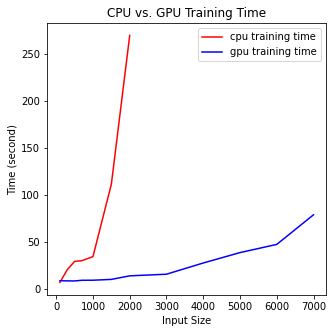

In [42]:
# # plot with various axes scales
# plt.figure()

# CPU vs GPU training
plt.figure(figsize=(5,5))
plt.plot(cpu_size_vec, cpu_training_time, 'r-', label='cpu training time')
plt.plot(gpu_size_vec, gpu_training_time, 'b-', label='gpu training time')
plt.ylabel('Time (second)')
plt.xlabel('Input Size')
plt.title('CPU vs. GPU Training Time')
# plt.grid(True)



plt.legend()
plt.show()

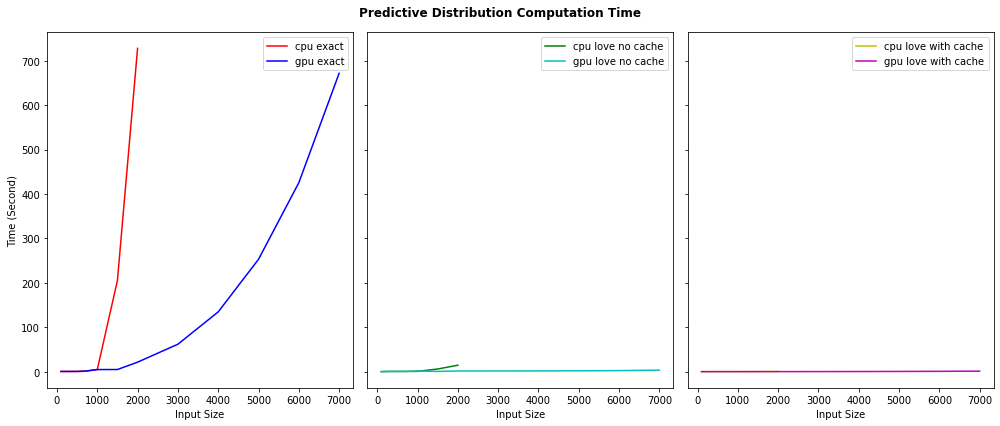

In [43]:
# Predictive Distribution Computation Time

# # Initialize plots
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6), sharey=True)

plt.suptitle('Predictive Distribution Computation Time', fontweight='bold')

ax1.plot(cpu_size_vec, cpu_exact_meancovar, 'r-', label='cpu exact')
ax1.plot(gpu_size_vec, gpu_exact_meancovar, 'b-', label='gpu exact')
ax1.legend()


plt.subplot(132)
ax2.plot(cpu_size_vec, cpu_love_meancovar, 'g-', label='cpu love no cache')
ax2.plot(gpu_size_vec, gpu_love_meancovar, 'c-', label='gpu love no cache')
ax2.legend()
# plt.ylabel('Time')
# plt.xlabel('Input Size')

plt.subplot(133)
ax3.plot(cpu_size_vec, cpu_love_meancovar_cache, 'y-', label='cpu love with cache')
ax3.plot(gpu_size_vec, gpu_love_meancovar_cache, 'm-', label='gpu love with cache')
ax3.legend()

plt.setp([ax1,ax2,ax3], xlabel='Input Size')
plt.setp(ax1, ylabel='Time (Second)')

plt.legend()
plt.tight_layout()